# PART I

### Some imports

In [69]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [70]:
tesla_df = pd.read_csv("./docs/Homework3 - TSLA.csv")
tesla_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Data Preperation

In [71]:
tesla_data = tesla_df
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)

tesla_data.sort_index(inplace=True)
tesla_data = tesla_data[:2950]
data = tesla_data[['Close']].values  # Use 'Close' price for prediction

### Important Tricky
> I have tesla data which includes 2956 rows. For trainin 2956 * 0.7 = 2069.2

> Thats impossible to continue. I set the data 2950 because 2950 * 0.7 = 2065

> So, thats very important to continue with train and test data.

### Scaling 

In [72]:
scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.7)  # (70% train, 30% test)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


def create_sequences(data, seq_length):  # Create sequences for LSTM
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)


seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # Reshape data to fit LSTM input
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Shape of training set: {}".format(X_train.shape))
print("Shape of test set: {}".format(X_test.shape))

Shape of training set: (2005, 60, 1)
Shape of test set: (825, 60, 1)


### The Model

In [73]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 2.8045e-04 - val_loss: 0.0065
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.0702e-06 - val_loss: 0.0069
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.0853e-06 - val_loss: 0.0058
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.4914e-06 - val_loss: 0.0057
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.8624e-06 - val_loss: 0.0050
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.7800e-06 - val_loss: 0.0051
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.9636e-06 - val_loss: 0.0050
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.1334e-06 - val_loss: 0.0045
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.7366e-06 - val_loss: 0.0042
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.0343e-06 - val_loss: 0.0037


### Predictions

In [74]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inv, predictions))
print(f'RMSE: {rmse}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 74.53851692019516


### Plot the results

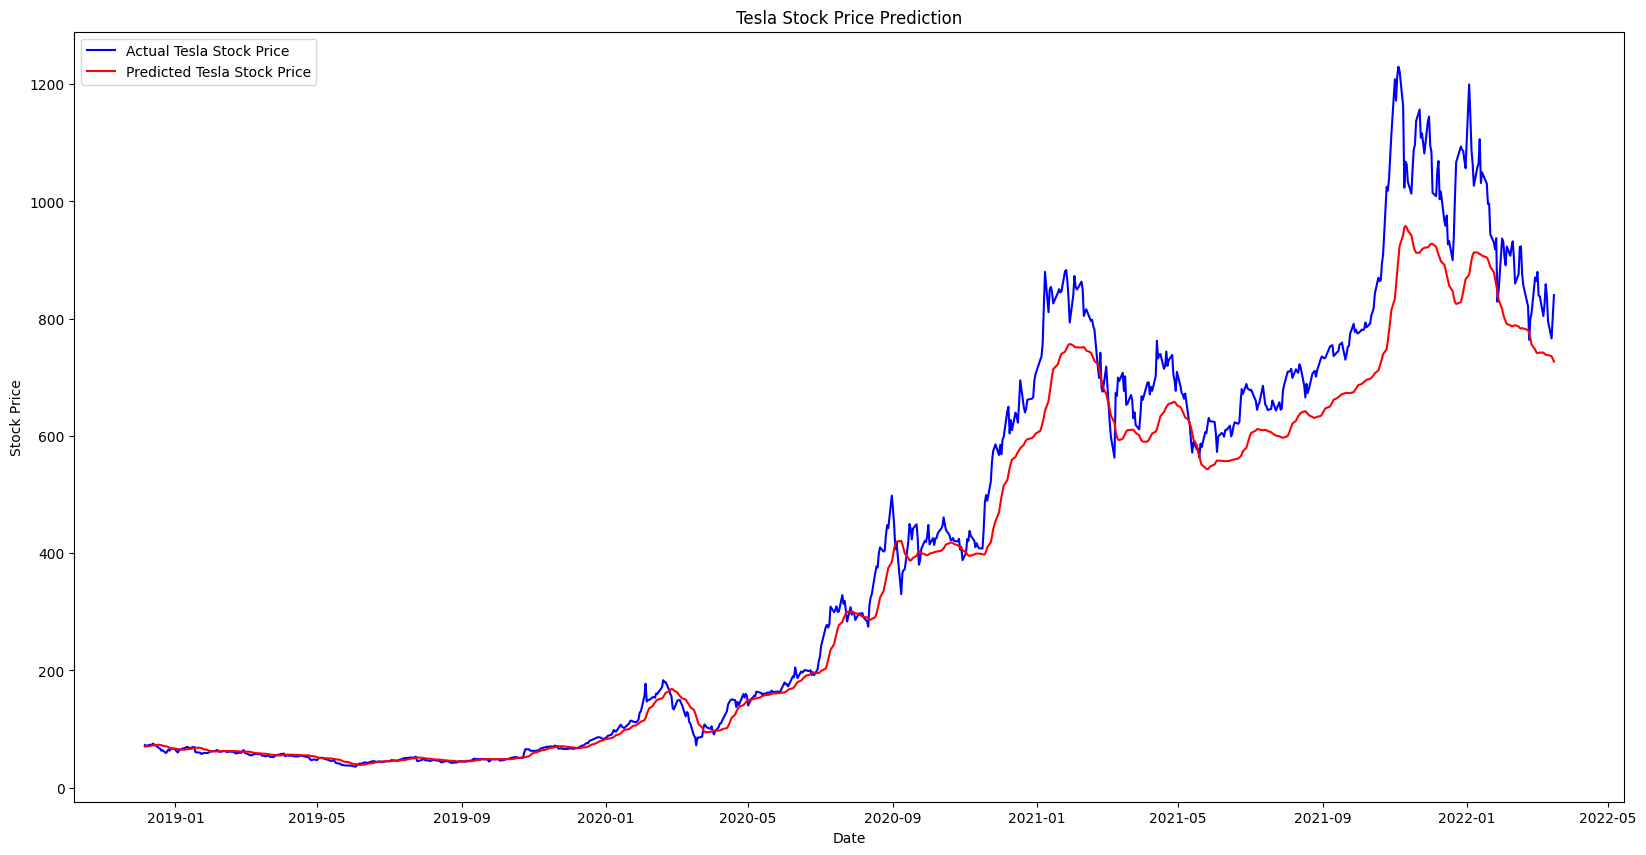

In [75]:
plt.figure(figsize=(20, 10))
plt.plot(tesla_data.index[train_size + seq_length:], y_test_inv, color='blue', label='Actual Tesla Stock Price')
plt.plot(tesla_data.index[train_size + seq_length:], predictions, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### My Comment

The predicted data is almost the same as the actual data, I saw small deviations towards the end, we can prevent this by increasing the number of epochs and the amount of sequences. 

If it does not increase after trying this way, maybe we can see by adding another layer into LSTM.

### Repeat the above using an additional feature. Go for Data Preperation

In [76]:
gold_data = pd.read_csv('./docs/gold.csv')
gold_data.sort_values('Date', inplace=True)
gold_data['Date'] = pd.to_datetime(gold_data['Date'])

combined = pd.merge(tesla_data, gold_data, on='Date', how='inner')  # Merge on date with inner interseciton
combined_data = combined[['Date', 'Close_x', 'Close_y']]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data[['Close_x', 'Close_y']])

### Create sequence with gold data's

In [77]:
def create_dataset_with_gold(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]  # Use 'Close' and 'Gold' prices
        X.append(a)
        Y.append(dataset[i + time_step, :])  # Predict both 'Close_x' and 'Close_y'
    return np.array(X), np.array(Y)

In [78]:
X, Y = create_dataset_with_gold(scaled_combined_data, seq_length)

train_size = int(len(X) * 0.7)  # (70% train, 30% test)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

### The new Model with new Feature Of GOld

In [79]:
model_comb = Sequential()
model_comb.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 2)))
model_comb.add(LSTM(50, return_sequences=False))
model_comb.add(Dense(25))
model_comb.add(Dense(2))

model_comb.compile(optimizer='adam', loss='mean_squared_error')

In [80]:
history_comb = model_comb.fit(X_train, Y_train, batch_size=32, epochs=10)
# history_comb = model_comb.fit(X_train_comb, y_train_comb, epochs=10, batch_size=32, validation_data=(X_test_comb, y_test_comb))

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0118
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.8259e-04
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.3732e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.8149e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.3545e-04
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.7604e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.7184e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.5617e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.1255e-04
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.9252e-04


### Predictions

In [81]:
train_predict = model_comb.predict(X_train)
test_predict = model_comb.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
print(f'RMSE (with gold): {test_rmse}')

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE (with gold): 0.0889149220245044


### Plot the results

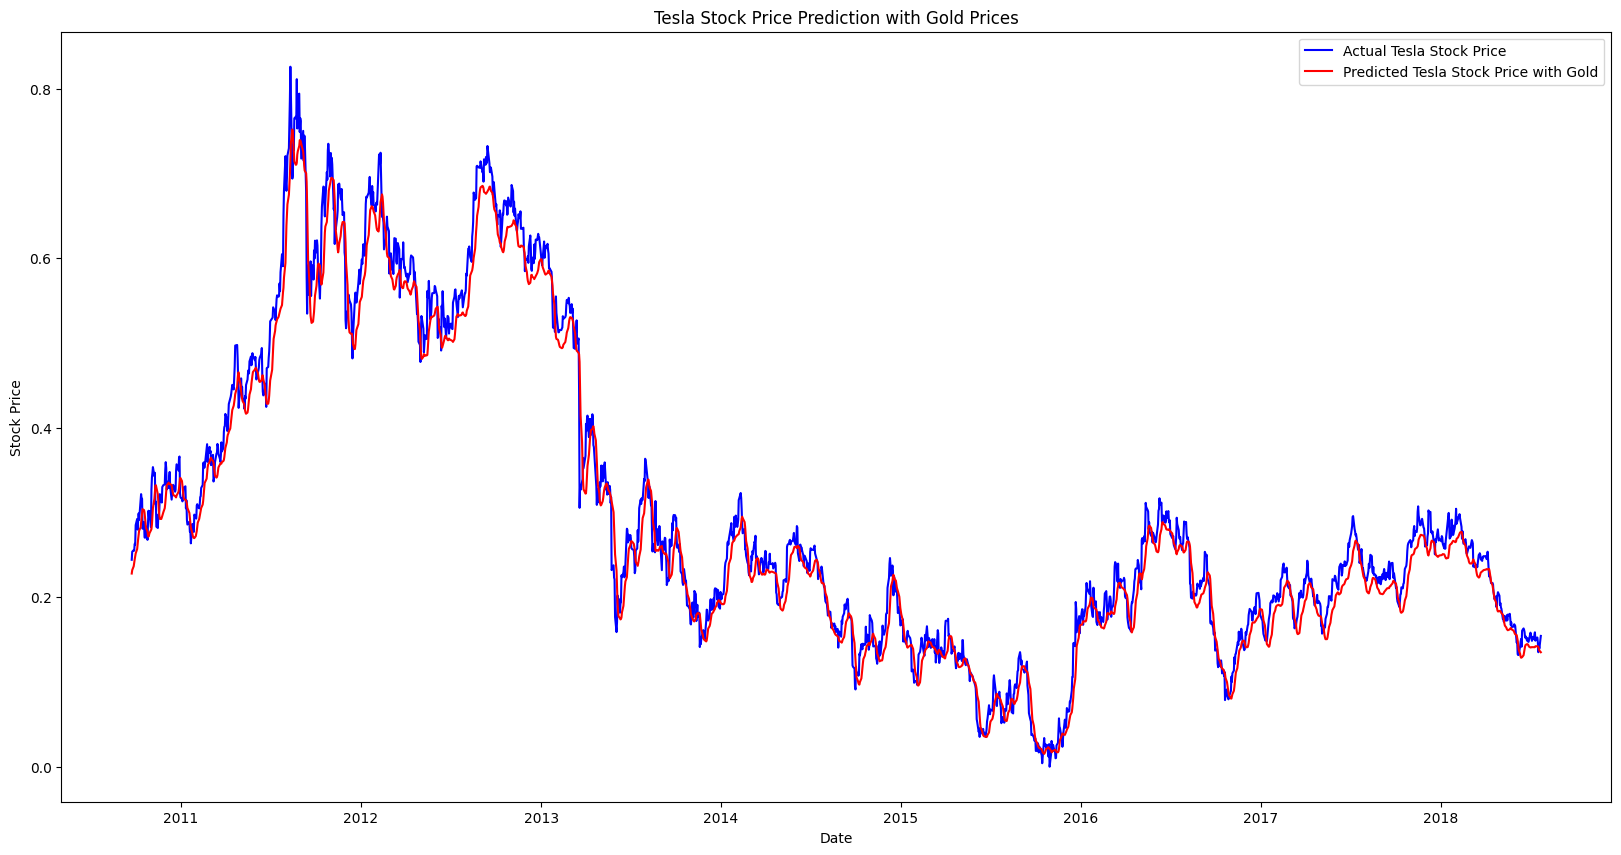

In [82]:
plt.figure(figsize=(20, 10))
plt.plot(tesla_data.index[seq_length:train_size + seq_length:], Y_train[:, 1], color='blue', label='Actual Tesla Stock Price')
plt.plot(tesla_data.index[seq_length:train_size + seq_length:], train_predict[:, 1], color='red', label='Predicted Tesla Stock Price with Gold')
plt.title('Tesla Stock Price Prediction with Gold Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### My Commnet

The predicted data are almost exactly the same as the actual data, with minor deviations at the extremes. We can prevent this by increasing the number of epochs and the amount of sequences. 

If it does not increase after trying this way, maybe we can see by adding another layer into LSTM.

# PART II

### Some imports

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics

### Data Preperation

In [102]:
tesla_df = pd.read_csv("./docs/Homework3 - TSLA.csv")
tesla_data = tesla_df
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)
tesla_data.sort_index(inplace=True)
tesla_data = tesla_data[:2950]

train_size = int(len(tesla_data) * 0.7)
train_data = tesla_data[:train_size]
test_data = tesla_data[train_size:]

train_data = train_data["Close"].tolist()
test_data = test_data["Close"].tolist()

### Create sequence

In [103]:
def create_sequences_for_transformers(obs, sequence_size):
    x = []
    y = []

    for i in range(len(obs) - sequence_size):
        #print(i) # if you wanna see, you will uncomment
        window = obs[i:(i + sequence_size)]
        after_window = obs[i + sequence_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)

    return np.array(x), np.array(y)


seq_length = 10  #  for better performance
x_train, y_train = create_sequences_for_transformers(train_data, seq_length)
x_test, y_test = create_sequences_for_transformers(test_data, seq_length)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (2055, 10, 1)
Shape of test set: (875, 10, 1)


### The Encoder: Normalization, Attention & Feed Forward

In [104]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

### The Model with Transformer

In [105]:
def build_model(
        input_shape,
        head_size,
        ff_dim,
        num_heads,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)  # Pooling
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

### Go for Model Compile

In [106]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape=input_shape,
    num_transformer_blocks=4,
    head_size=256,
    num_heads=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
    ff_dim=4,
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="mean_squared_error")
callbacks = [keras.callbacks.EarlyStopping(restore_best_weights=True, patience=10, )]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 484.8237 - val_loss: 607.6144
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 215.9145 - val_loss: 154.8764
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 157.3382 - val_loss: 34.4395
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 135.4249 - val_loss: 17.3351
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 132.6356 - val_loss: 13.8638


In [107]:
model.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ input_layer_13[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_84          │ (None, 10, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_49 (Add)        │ (None, 10, 1)     │          0 │ dropout_84[0][0], │
│                     │                   │            │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_49[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 10, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_85          │ (None, 10, 4)     │          0 │ conv1d_49[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 10, 1)     │          5 │ dropout_85[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_50 (Add)        │ (None, 10, 1)     │          0 │ conv1d_50[0][0],  │
│                     │                   │            │ add_49[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_50[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_87          │ (None, 10, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_51 (Add)        │ (None, 10, 1)     │          0 │ dropout_87[0][0], │
│                     │                   │            │ add_50[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_51[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 10, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_88          │ (None, 10, 4)     │          0 │ conv1d_51[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 10, 1)     │          5 │ dropout_88[0][0]

 Total params: 90,845 (354.87 KB)

 Trainable params: 30,281 (118.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,564 (236.58 KB)

### Predictions

In [108]:
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print(f"RMSE: {format(score)}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
RMSE: 39.56920585485417


### Plot the results

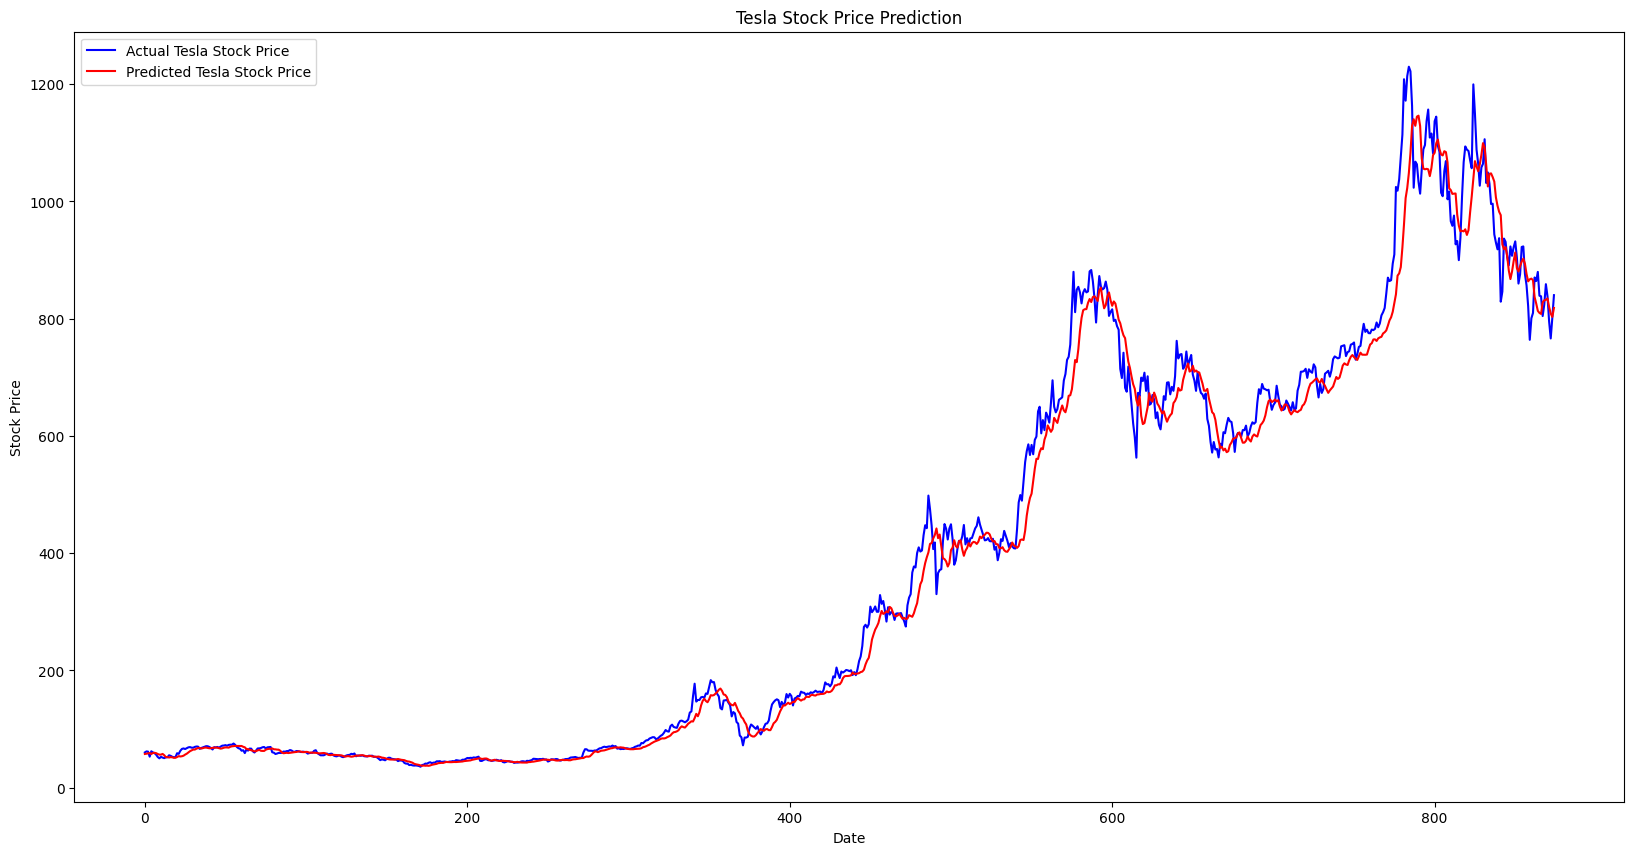

In [109]:
plt.figure(figsize=(20, 10))
plt.plot(y_test, color='blue', label='Actual Tesla Stock Price')
plt.plot(pred, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### My Commnet

The predicted data are almost exactly the same as the actual data, with minor deviations at the extremes. We can prevent this by increasing the number of epochs and the amount of sequences. 

If it does not increase after trying this way, maybe we can see by adding another layer into Transformers.

### Repeat the above using an additional feature. Go for Data Preperation

In [110]:
gold_data = pd.read_csv('./docs/gold.csv')
gold_data.sort_values('Date', inplace=True)
gold_data['Date'] = pd.to_datetime(gold_data['Date'])

combined = pd.merge(tesla_data, gold_data, on='Date', how='inner')
combined_data = np.array(combined[['Close_x', 'Close_y']])
# combined_data = combined[['Close_x', 'Close_y']]

### Create sequence with gold data's

In [111]:
X, Y = create_dataset_with_gold(combined_data, seq_length)

print("Shape of training set: {}".format(X.shape))
print("Shape of test set: {}".format(Y.shape))

Shape of training set: (2867, 10, 2)
Shape of test set: (2867, 2)


In [112]:
train_size = int(len(X) * 0.7)  # (70% train, 30% test)
x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (2006, 10, 2)
Shape of test set: (861, 10, 2)


### The Encoder With Gold: Normalization, Attention & Feed Forward

In [113]:
def transformer_encoder_with_gold(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(activation="relu", kernel_size=1, filters=ff_dim, )(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(kernel_size=1, filters=inputs.shape[-1])(x)
    return x + res

### The Model With Transformer & Gold Feature

In [114]:
def build_model_with_gold(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder_with_gold(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    # I Added dense layer for new gold feature, 
    # so output give us two dense like Close_x from tesla data and Close_y from gold data, like part I
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(2)(x)
    return keras.Model(inputs, outputs)

### Go for Model Compile

In [115]:
input_shape = x_train.shape[1:]

model_with_gold = build_model_with_gold(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_with_gold.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=1e-4))
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model_with_gold.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 948783.3750 - val_loss: 580981.5625
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 689796.9375 - val_loss: 425975.5625
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 497643.6562 - val_loss: 284729.1875
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 332455.7500 - val_loss: 170668.2188
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 211410.2344 - val_loss: 81724.3281
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 133589.5469 - val_loss: 28676.9316
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 91586.5469 - val_loss: 8138.2295
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 72758.4531 - val_loss: 2785.8438
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 72085.6094 - val_loss: 2151.0071
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 67922.3281 - val_loss: 1685.1700
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 668

In [116]:
model_with_gold.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 10, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ input_layer_14[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 2)     │     11,266 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_97          │ (None, 10, 2)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_57 (Add)        │ (None, 10, 2)     │          0 │ dropout_97[0][0], │
│                     │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ add_57[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 10, 4)     │         12 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_98          │ (None, 10, 4)     │          0 │ conv1d_57[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 10, 2)     │         10 │ dropout_98[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_58 (Add)        │ (None, 10, 2)     │          0 │ conv1d_58[0][0],  │
│                     │                   │            │ add_57[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ add_58[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 2)     │     11,266 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_100         │ (None, 10, 2)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_59 (Add)        │ (None, 10, 2)     │          0 │ dropout_100[0][0… │
│                     │                   │            │ add_58[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ add_59[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 10, 4)     │         12 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_101         │ (None, 10, 4)     │          0 │ conv1d_59[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 10, 2)     │         10 │ dropout_101[0][0

 Total params: 187,016 (730.54 KB)

 Trainable params: 62,338 (243.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 124,678 (487.03 KB)

### Predictions

In [117]:
pred = model_with_gold.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print('RMSE (with gold): {}'.format(score))

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
RMSE (with gold): 317.12321608516595


### Plot the results

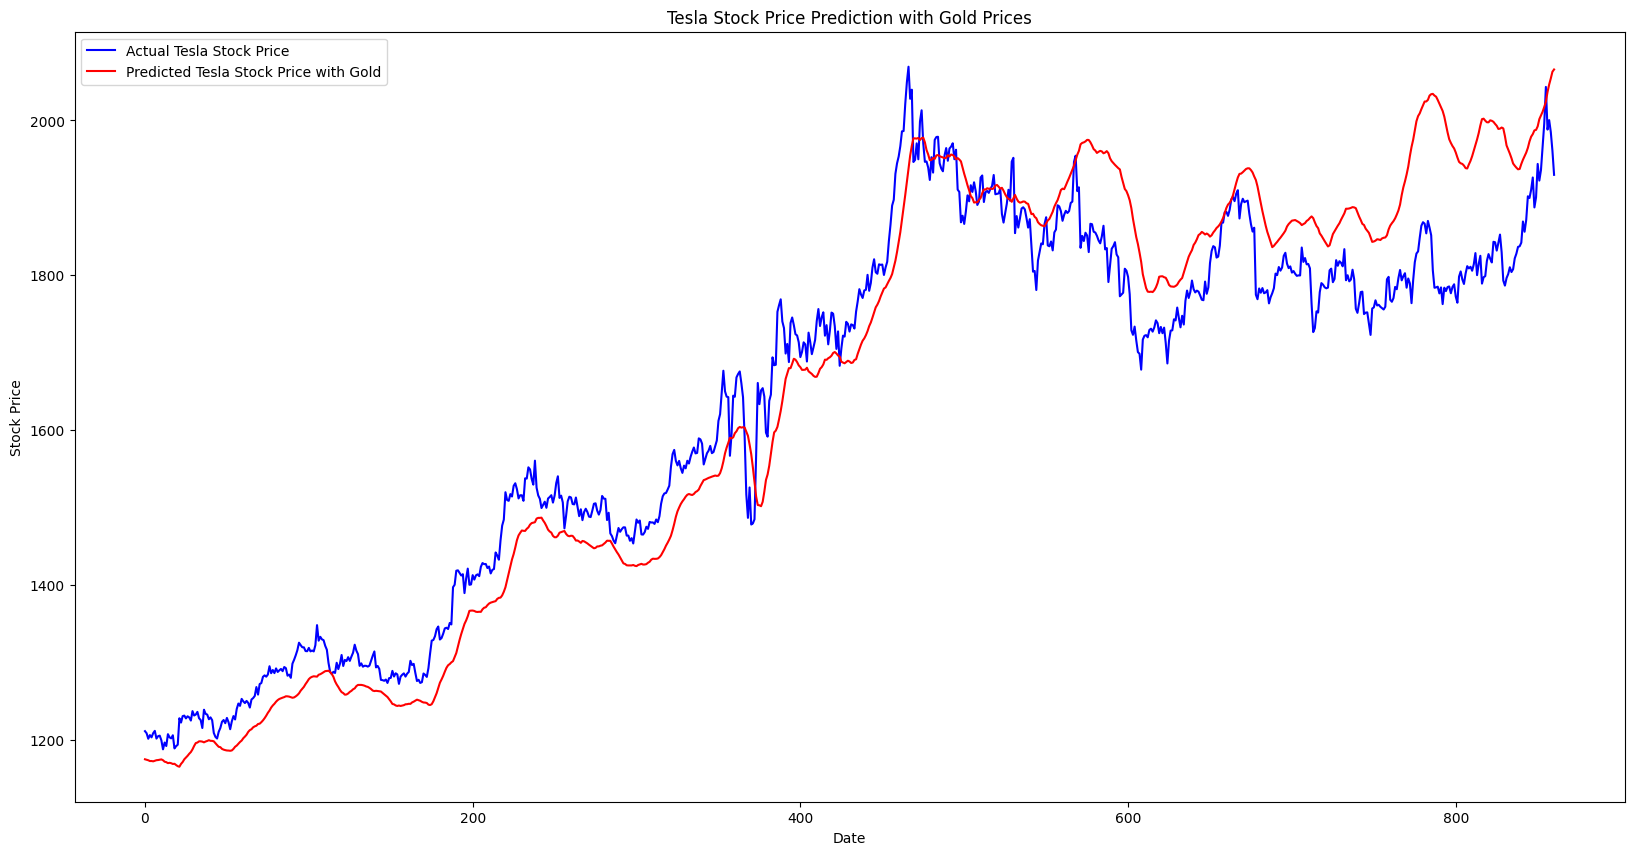

In [118]:
plt.figure(figsize=(20, 10))
plt.plot(y_test[:, 1], color='blue', label='Actual Tesla Stock Price')
plt.plot(pred[:, 1], color='red', label='Predicted Tesla Stock Price with Gold')
plt.title('Tesla Stock Price Prediction with Gold Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### My Commnet

Although the predicted data and the actual data were the same in terms of pattern, there were minor deviations from the main line. 

We can prevent this by increasing the number of epochs and the amount of sequences. 

If it does not increase after trying this way, maybe we can solve it by adding another layer into Transformers.